In [1]:
sys.path.append('../')

import numpy as np
import math
import pandas as pd

# neural networks
import edward as ed
import tensorflow as tf

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# module loading settings
%load_ext autoreload
%autoreload 2

Size of features in training data: (3750, 1)
Size of output in training data: (3750,)
Size of features in test data: (1250, 1)
Size of output in test data: (1250,)


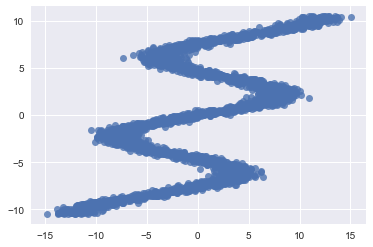

In [2]:
from sklearn.model_selection import train_test_split

def build_toy_dataset(N):
    y_data = np.random.uniform(-10.5, 10.5, N)
    r_data = np.random.normal(size=N)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((N, 1))
    return train_test_split(x_data, y_data, random_state=42)

N = 5000  # number of data points
D = 1  # number of features

X_train, X_test, y_train, y_test = build_toy_dataset(N)
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

sns.regplot(X_train, y_train, fit_reg=False);

In [3]:
X_ph = tf.placeholder(tf.float32, [None, D])
y_ph = tf.placeholder(tf.float32, [None])

In [4]:
from edward.models import Categorical, Mixture, Normal
from tensorflow.contrib import slim
from src.utils import sample_center_points

k = 70

hidden1 = slim.fully_connected(X_ph, 15)
hidden2 = slim.fully_connected(hidden1, 15)
w = slim.fully_connected(hidden2, k, activation_fn=tf.nn.softplus)

locs = sample_center_points(y_train, method='agglomerative', k=k)
locs = tf.multiply(tf.fill([tf.shape(X_ph)[0], k], 1.), locs)
scales = tf.fill([tf.shape(X_ph)[0], k], 0.1)

cat = Categorical(logits=w)
components = [Normal(mu=loc, sigma=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs)),
                     tf.unstack(tf.transpose(scales)))]

y = Mixture(cat=cat, components=components, value=tf.zeros_like(y_ph))

In [5]:
inference = ed.MAP(data={y: y_ph})

In [6]:
inference.initialize(var_list=tf.trainable_variables())

sess = ed.get_session()
tf.global_variables_initializer().run()

In [7]:
n_epoch = 1000
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
  info_dict = inference.update(feed_dict={X_ph: X_train, y_ph: y_train})
  train_loss[i] = info_dict['loss']
  test_loss[i] = sess.run(inference.loss, feed_dict={X_ph: X_test, y_ph: y_test})
  inference.print_progress(info_dict)

1000/1000 [100%] ██████████████████████████████ Elapsed: 32s | Loss: 4885.671


In [8]:
pred_weights, pred_means, pred_std = \
    sess.run([tf.nn.softmax(w), locs, scales], feed_dict={X_ph: X_test})

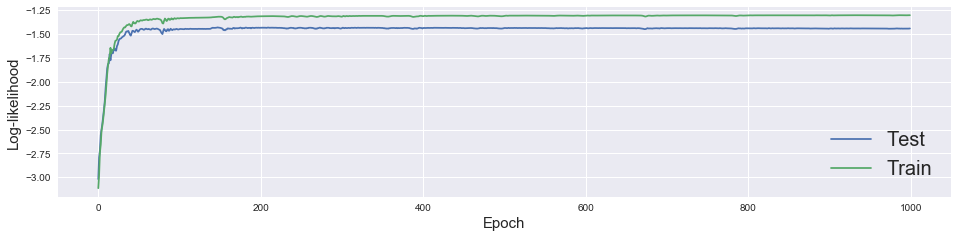

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), -test_loss / len(X_test), label='Test')
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()

In [10]:
def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """Draws samples from mixture model.

    Returns 2 d array with input X and sample from prediction of mixture model.
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(
          zip(pred_weights, pred_means, pred_std)):
    index = np.random.choice(to_choose_from, p=weights)
    samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
    samples[j, 0] = x[j]
    if j == amount - 1:
        break
    return samples

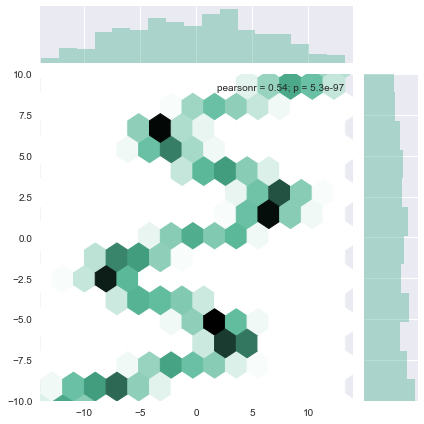

In [11]:
a = sample_from_mixture(X_test, pred_weights, pred_means,
                        pred_std, amount=len(X_test))
sns.jointplot(a[:, 0], a[:, 1], kind="hex", color="#4CB391",
              ylim=(-10, 10), xlim=(-14, 14))
plt.show()